In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import casadi
import os
import statsmodels.formula.api as smf
from functions import generic

# Yearly data

### Maine prices, load, and temperature

In [2]:
df = pd.read_excel(os.getcwd()+'/data/gridworks_yearly_data.xlsx', header=3, index_col = 0)
df.index = pd.to_datetime(df.index)
df.index.name = None
df['elec'] = df['Total Delivered Energy Cost ($/MWh)']
df['load'] = df['House Power Required AvgKw'] *0.8
df['T_OA'] = df['Outside Temp F']
df['T_OA'] = df['T_OA'].apply(lambda x: round(5/9 * (x-32),2))
df = df[['elec', 'load', 'T_OA']]
df.head()

,elec,load,T_OA
2022-01-01 00:00:00,69.39,4.728,-3.89
2022-01-01 01:00:00,64.75,4.616,-3.33
2022-01-01 02:00:00,63.84,4.536,-2.78
2022-01-01 03:00:00,63.31,4.616,-3.33
2022-01-01 04:00:00,63.17,4.568,-3.33


### CalFlexHub prices

In [3]:
CFH_prices = {
    'WinterHDP': [0.1718, 0.1445, 0.0202, 0.011, 0.0331, 0.11, 0.2672, 0.3077, 0.2163, 0.1584, 
                  0.1264, 0.1047, 0.1318, 0.1835, 0.2485, 0.3123, 0.3961, 0.5254, 0.4974, 0.4525, 
                  0.3918, 0.3113, 0.1998, 0.1106], 
    'SpringHDP': [0.1714, 0.144, 0.1385, 0.1518, 0.1829, 0.2713, 0.4659, 0.5328, 0.28, 0.1158, 
                  0.0398, 0.0196, 0.011, 0.0188, 0.0255, 0.0632, 0.0957, 0.2358, 0.4931, 0.6618, 
                  0.5364, 0.4116, 0.2905, 0.2209], 
    'SummerHDP': [0.0864, 0.0587, 0.0385, 0.0246, 0.0165, 0.0215, 0.0359, 0.0206, 0.0106, 0.0192, 
                  0.0309, 0.0612, 0.0925, 0.1244, 0.1667, 0.2148, 0.3563, 0.4893, 0.7098, 0.7882, 
                  0.5586, 0.3326, 0.2152, 0.1487], 
    'FallHDP': [0.2052, 0.1284, 0.0792, 0.0531, 0.0551, 0.1193, 0.2737, 0.27, 0.0916, 0.011, 0.0389, 
                0.0238, 0.0366, 0.0611, 0.0998, 0.1888, 0.3046, 0.5198, 0.7248, 0.6936, 0.4961, 0.3569, 
                0.1822, 0.0413]
 }

yearly_elecs = []
for j in range(1,13):
    if j==1: yearly_elecs.extend(CFH_prices['WinterHDP']*31)
    if j==2: yearly_elecs.extend(CFH_prices['WinterHDP']*28)
    if j==3: yearly_elecs.extend(CFH_prices['SpringHDP']*31)
    if j==4: yearly_elecs.extend(CFH_prices['SpringHDP']*30)
    if j==5: yearly_elecs.extend(CFH_prices['SpringHDP']*31)
    if j==6: yearly_elecs.extend(CFH_prices['SummerHDP']*30)
    if j==7: yearly_elecs.extend(CFH_prices['SummerHDP']*31)
    if j==8: yearly_elecs.extend(CFH_prices['SummerHDP']*31)
    if j==9: yearly_elecs.extend(CFH_prices['FallHDP']*30)
    if j==10: yearly_elecs.extend(CFH_prices['FallHDP']*31)
    if j==11: yearly_elecs.extend(CFH_prices['FallHDP']*30)
    if j==12: yearly_elecs.extend(CFH_prices['WinterHDP']*31)

### Edison retail prices

In [4]:
summer_week = ([0.37]*17 + [0.75]*3 + [0.37]*4)*5 + ([0.37]*17 + [0.56]*3 + [0.37]*4)*2
winter_week = ([0.4]*8 + [0.35]*9 + [0.62]*3 + [0.4]*4)*7
edison_yearly = winter_week*22 + summer_week*18 + winter_week*12 + winter_week[:24]
edison_yearly = edison_yearly*2

### COP estimation as a function of temperature

In [5]:
# Get COP regression as a function of T_OA
T_OA_table = list(range(-15,40,5))
COP_table = 1.7,2.3,2.3,2.43,2.63,2.78,3.36,3.79,3.99,4.12,5.10
COP_df = pd.DataFrame({'temp':T_OA_table,'cop':COP_table})
mod = smf.ols(formula='cop ~ temp', data=COP_df)
np.random.seed(2) 
res = mod.fit()

def COP(T_OA):
    return round(res.params.Intercept+T_OA*res.params.temp,2)

# Estimated CAPEX ($/year)

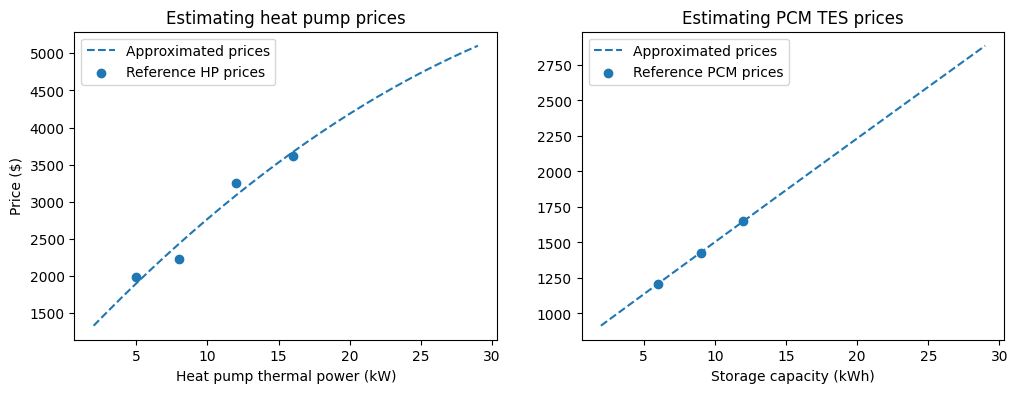

In [6]:
# HP prices
A_hp = [5, 8, 12, 16]
C_hp = [1984, 2235, 3257, 3616]
C_polyfit_hp = np.polyfit(A_hp, C_hp, 2)

# PCM prices
A_pcm = [6, 9, 12]
C_pcm = [2416, 2857, 3297]
C_pcm = [x/2 for x in C_pcm]
C_polyfit_pcm = np.polyfit(A_pcm, C_pcm, 2)

# Plot
prices_hp = [np.polyval(C_polyfit_hp, x) for x in range(2,30)]
prices_pcm = [np.polyval(C_polyfit_pcm, x) for x in range(2,30)]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(range(2,30), prices_hp, label='Approximated prices', linestyle='dashed')
axes[0].scatter(A_hp, C_hp, label='Reference HP prices')
axes[0].set_xlabel("Heat pump thermal power (kW)")
axes[0].set_ylabel("Price ($)")
axes[0].set_title('Estimating heat pump prices')
axes[0].legend(loc='upper left')
axes[1].plot(range(2,30), prices_pcm, label='Approximated prices', linestyle='dashed')
axes[1].scatter(A_pcm, C_pcm, label='Reference PCM prices')
axes[1].set_xlabel("Storage capacity (kWh)")
axes[1].set_title('Estimating PCM TES prices')
axes[1].legend()
#plt.savefig('capex_subplots.jpg', dpi=300)
plt.show()

In [7]:
def estimated_capex(storage_size, heatpump_size, lifetime):
    
    capex_HP = np.polyval(C_polyfit_hp, heatpump_size)
    capex_TES = np.polyval(C_polyfit_pcm, storage_size)

    capex = capex_HP + capex_TES
    capex_yearly = capex / lifetime

    return round(capex_yearly,3)

# Optimal OPEX ($/horizon)

In [8]:
def optimal_opex(max_storage, max_Q_HP, forecasts, PLOT):

    # Unpack forecasts and get parameters
    N = forecasts['horizon']
    elec = forecasts['elec']
    load = forecasts['load']
    COP_list = [COP(T) for T in forecasts['T_OA']]
    min_Q_HP = max_Q_HP*0.2

    # Initialize    
    opti = casadi.Opti('conic')
 
    # -----------------------------
    # Variables and solver
    # -----------------------------
    
    Q_stor = opti.variable(1,N+1)   # state
    Q_HP = opti.variable(1,N)       # input
    delta_HP = opti.variable(1,N)   # input
    Q_HP_onoff = opti.variable(1,N) # input (derived)
    
    # delta_HP is a discrete variable (binary)
    discrete_var = [0]*(N+1) + [0]*N + [1]*N + [0]*N

    # Solver
    solver_opts = {'discrete':discrete_var, 'gurobi.OutputFlag':0}
    opti.solver('gurobi', solver_opts)
    
    # -----------------------------
    # Constraints
    # -----------------------------
    
    # Initial Q_stor level
    opti.subject_to(Q_stor[0] == 0)

    # Constraints at every time step
    for t in range(N+1):

        # Bounds on storage
        opti.subject_to(Q_stor[t] >= 0)
        opti.subject_to(Q_stor[t] <= max_storage)

        if t < N:
            
            # System dynamics
            opti.subject_to(Q_stor[t+1] == Q_stor[t] + Q_HP_onoff[t] - load[t])
    
            # Bounds on delta_HP
            opti.subject_to(delta_HP[t] >= 0)
            opti.subject_to(delta_HP[t] <= 1)
        
            # Bounds on Q_HP
            opti.subject_to(Q_HP[t] <= max_Q_HP)    
            opti.subject_to(Q_HP[t] >= min_Q_HP*delta_HP[t])
        
            # Bilinear to linear
            opti.subject_to(Q_HP_onoff[t] <= max_Q_HP*delta_HP[t])
            opti.subject_to(Q_HP_onoff[t] >= min_Q_HP*delta_HP[t])
            opti.subject_to(Q_HP_onoff[t] <= Q_HP[t] + min_Q_HP*(delta_HP[t]-1))
            opti.subject_to(Q_HP_onoff[t] >= Q_HP[t] + max_Q_HP*(delta_HP[t]-1))
    
    # -----------------------------
    # Objective
    # -----------------------------
    
    obj = sum(Q_HP_onoff[t]*elec[t]/COP_list[t] for t in range(N))
    opti.minimize(obj)

    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sol = opti.solve()

    Q_opt = sol.value(Q_HP_onoff)
    stor_opt = sol.value(Q_stor)
    obj_opt = round(sol.value(obj),3)

    if PLOT:
        fig, ax = plt.subplots(1,1, figsize=(13,4))
        ax2 = ax.twinx()
        ax2.step(range(N), elec, where='post', color='gray', alpha=0.2)
        ax.step(range(N), Q_opt, where='post', color='blue', alpha=0.6)
        ax.step(range(N), load, where='post', color='red', alpha=0.6)
        ax.plot(stor_opt, color='orange', alpha=0.6)
        plt.show()

    return obj_opt

# TOTEX ($/year)

In [9]:
def yearly_totex(storage_size, heatpump_size, lifetime, forecasts, PLOT):

    try:
        capex = estimated_capex(storage_size, heatpump_size, lifetime)
        opex = optimal_opex(storage_size, heatpump_size, forecasts, PLOT)
        totex = capex + opex

        if PLOT:
            print(f'CAPEX = {capex} $/year')
            print(f'OPEX = {opex} $/horizon')

        print(f'TOTEX = {totex} $/horizon')
        
    except Exception as e:
        return np.nan

    return totex

#### Examples

In [10]:
# Equipment lifetime, in years
lifetime = 20

# 24 hour simulation
forecasts = {
    'horizon': 24,
    'elec': yearly_elecs[:24],
    'load': list(df.load)[:24],
    'T_OA': list(df.T_OA)[:24],
    }

#yearly_totex(42, 12, lifetime, forecasts, True)

# Yearly simulation
forecasts = {
    'horizon': len(df),
    'elec': yearly_elecs,
    'load': list(df.load),
    'T_OA': list(df.T_OA),
    }

#totex = yearly_totex(20, 12, lifetime, forecasts, True)
#totex = yearly_totex(50, 12, lifetime, forecasts, True)

# Sizing

In [11]:
# Create a grid of equipment sizes
storage_range = np.linspace(20, 90, 6)
heatpump_range = np.linspace(5, 35, 6)
storage_grid, heatpump_grid = np.meshgrid(storage_range, heatpump_range)

# Get the TOTEX for all combinations in the grid
#totex_values = np.vectorize(yearly_totex, excluded=['lifetime', 'forecasts', 'PLOT'])(storage_grid, heatpump_grid, lifetime, forecasts, False)
#print(totex_values)

In [12]:
'''
# Find the minimum
min_index = np.unravel_index(np.nanargmin(totex_values), totex_values.shape)
min_storage_value = storage_grid[min_index]
min_heatpump_value = heatpump_grid[min_index]

# Plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
surface = ax.plot_surface(storage_grid, heatpump_grid, totex_values, cmap='viridis', alpha=0.7)
ax.scatter(min_storage_value, min_heatpump_value, totex_values[min_index], color='red', s=100)
ax.set_title(f'Lowest total cost reached for\nHeat pump: {round(min_heatpump_value)} kW, Storage: {round(min_storage_value)} kWh')
ax.set_xlabel('Storage capacity [kWh]')
ax.set_ylabel('Heat pump capacity [kWh]')
ax.set_zlabel('Cost')
ax.set_zticks([])
plt.show()
'''

"\n# Find the minimum\nmin_index = np.unravel_index(np.nanargmin(totex_values), totex_values.shape)\nmin_storage_value = storage_grid[min_index]\nmin_heatpump_value = heatpump_grid[min_index]\n\n# Plot\nfig = plt.figure(figsize=(10,8))\nax = fig.add_subplot(projection='3d')\nsurface = ax.plot_surface(storage_grid, heatpump_grid, totex_values, cmap='viridis', alpha=0.7)\nax.scatter(min_storage_value, min_heatpump_value, totex_values[min_index], color='red', s=100)\nax.set_title(f'Lowest total cost reached for\nHeat pump: {round(min_heatpump_value)} kW, Storage: {round(min_storage_value)} kWh')\nax.set_xlabel('Storage capacity [kWh]')\nax.set_ylabel('Heat pump capacity [kWh]')\nax.set_zlabel('Cost')\nax.set_zticks([])\nplt.show()\n"

# PARETO

### Elec: CFH, Load: Maine 80%

/var/folders/c3/d3fq0hlj3j7gpdh35ylfyy1h0000gp/T/ipykernel_6475/3378886184.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df.load[i] > 0:
/var/folders/c3/d3fq0hlj3j7gpdh35ylfyy1h0000gp/T/ipykernel_6475/3378886184.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  noisy_load.append(noise[count] + df.load[i])


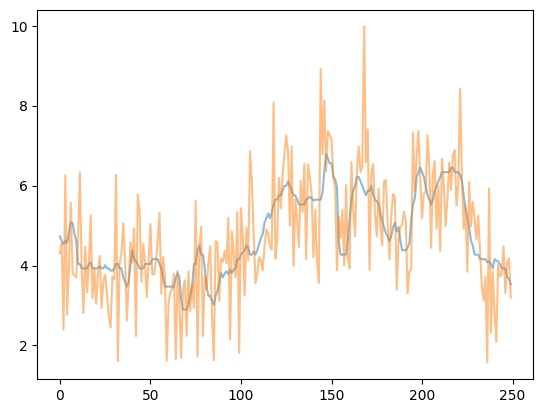

In [13]:
# Adding noise
noise = np.random.normal(loc=0, scale=1, size=len(df[df.load>0].load))

noisy_load = []
count = 0
for i in range(len(df.load)):
    if df.load[i] > 0:
        noisy_load.append(noise[count] + df.load[i])
        count += 1
    else:
        noisy_load.append(0)

plt.plot(list(df.load)[:250], alpha=0.5)
plt.plot(noisy_load[:250], alpha=0.5)
plt.show()

In [14]:
from functions import get_storage

# Extend lists for when the horizon goes into the second year
yearly_elecs = yearly_elecs*2
df = pd.concat([df, df], ignore_index=True)

def pareto_opex(storage_size, heatpump_size):
    PRINT = False

    soc = 0
    total_cost = 0
    daily_cost = 0
    control_final = []
    load_not_satisfied = []

    for hour in range(24*365):

        parameters = { 
            'horizon': 24,

            'elec_costs': yearly_elecs[hour:hour+24],
        
            'load': {'type': 'hourly', 
                    'value': [x for x in list(df.load[hour:hour+24])]},

            'control': {'type': 'range',
                        'max': [heatpump_size]*24,
                        'min': [0.2*heatpump_size]*24},
            
            'constraints': {'storage_capacity': True,
                            'max_storage': storage_size,
                            'initial_soc': soc,
                            'cheaper_hours': True,
                            'quiet_hours': False
                            },

            'hardware': {'heatpump': True,
                         'COP': [COP(T) for T in list(df.T_OA[hour:hour+24])]}
        }

        control = generic(parameters)
        storage = get_storage(control, parameters)

        # Adjust storage to what really happened
        storage[1] = storage[0] + control[0] - df.load[hour]
        # Add noise to load <=> add noise to stor_1 = stor_0 + Q_HP_0 - load_0
        if df.load[hour] > 0: 
            storage[1] += df.load[hour] - noisy_load[hour]
        # The storage going negative is the amount of load not satisfied!
        if storage[1] >=0:
            load_not_satisfied.append(0)
        else:
            load_not_satisfied.append(storage[1])

        soc = storage[1] if storage[1]<storage_size else storage_size
        soc = storage[1] if storage[1]>0 else 0

        cost = control[0] * parameters['elec_costs'][0] / parameters['hardware']['COP'][0]
        total_cost += cost
        daily_cost += cost
        control_final.append(control[0])

        if hour%24 == 0 and hour>0:
            print(f'Day {round(hour/24)-1}, cost {round(daily_cost,3)}')
            daily_cost = 0

        if PRINT:
            print(f'Hour {hour}, cost {round(cost,3)}, soc {round(soc,2)}, control {control[0]}')


    return round(total_cost,2), load_not_satisfied


In [15]:
def yearly_totex(storage_size, heatpump_size, lifetime):

    capex = estimated_capex(storage_size, heatpump_size, lifetime)
    opex, not_satisfied, elec = pareto_opex(storage_size, heatpump_size)
    totex = capex + opex*100

    print(f'\nCAPEX = {capex} $/year')
    print(f'OPEX = {opex} $/year')
    print(f'\nTOTEX = {round(capex+opex,3)} $/year')

    print(f'Average:{opex/120}')
    print(f'Average:{elec/120}')

    return not_satisfied

In [16]:
#not_satisfied = yearly_totex(28, 12, 20)

In [17]:
#plt.plot(not_satisfied)
#plt.show()

In [18]:
#nozeros = [x for x in not_satisfied if x<0]

#print(f'Number of hours where load is not satisfied: {len(nozeros)} hours')
#print(f'Median discomfort: {round(np.median(nozeros),3)}')
#print(f'Total discomfort: {round(sum(nozeros),3)}')

### Elec: Maine, Load: Maine 80%

In [19]:
CFH_prices = [0.1714, 0.144, 0.1385, 0.1518, 0.1829, 0.2713, 0.4659, 0.5328, 0.28, 0.1158,
              0.0398, 0.0196, 0.011, 0.0188, 0.0255, 0.0632, 0.0957, 0.2358, 0.4931, 0.6618, 
              0.5364, 0.4116, 0.2905, 0.2209]*300
CFH_prices = [x*1000 for x in CFH_prices]

In [27]:
from functions import get_storage

yearly_elecs = yearly_elecs*2
df = pd.concat([df, df], ignore_index=True)

def pareto_opex(storage_size, heatpump_size):
    PRINT = False

    soc = 0
    total_elec = 0
    total_cost = 0
    daily_cost = 0
    control_final = []

    for hour in range(120*24):

        parameters = { 
            'horizon': 24,

            'elec_costs': CFH_prices[hour:hour+24],
        
            'load': {'type': 'hourly', 
                    'value': list(df.load[hour:hour+24])},

            'control': {'type': 'range',
                        'max': [heatpump_size]*24,
                        'min': [0.2*heatpump_size]*24},
            
            'constraints': {'storage_capacity': True,
                            'max_storage': storage_size,
                            'initial_soc': soc,
                            'cheaper_hours': True,
                            'quiet_hours': False
                            },

            'hardware': {'heatpump': True,
                         'COP': [COP(T) for T in list(df.T_OA[hour:hour+24])]}
        }

        control = generic(parameters)
        storage = get_storage(control, parameters)
        soc = storage[1] if storage[1]<storage_size else storage_size

        cost = control[0] * parameters['elec_costs'][0] / parameters['hardware']['COP'][0]
        total_cost += cost
        total_elec += control[0] / parameters['hardware']['COP'][0]
        daily_cost += cost
        control_final.append(control[0])

        if hour%24 == 0 and hour>0:
            print(f'Day {round(hour/24)-1}, cost {round(daily_cost/1000,3)}')
            daily_cost = 0

        if PRINT:
            print(f'Hour {hour}, cost {round(cost,3)}, soc {round(soc,2)}, control {control[0]}')

    return round(total_cost/1000,2), 0, total_elec

In [28]:
yearly_totex(10.3, 10.35, 20)

Day 0, cost 6.44
Day 1, cost 5.281
Day 2, cost 4.274
Day 3, cost 5.057
Day 4, cost 7.964
Day 5, cost 11.208
Day 6, cost 12.698
Day 7, cost 8.709
Day 8, cost 12.827
Day 9, cost 8.405
Day 10, cost 3.554
Day 11, cost 8.635
Day 12, cost 11.794
Day 13, cost 10.069
Day 14, cost 7.426
Day 15, cost 8.314
Day 16, cost 19.929
Day 17, cost 18.513
Day 18, cost 13.428
Day 19, cost 14.088
Day 20, cost 16.316
Day 21, cost 9.908
Day 22, cost 6.169
Day 23, cost 6.105
Day 24, cost 5.669
Day 25, cost 4.642
Day 26, cost 5.019
Day 27, cost 8.279
Day 28, cost 11.596
Day 29, cost 12.014
Day 30, cost 11.695
Day 31, cost 7.458
Day 32, cost 6.989
Day 33, cost 5.495
Day 34, cost 5.974
Day 35, cost 9.797
Day 36, cost 10.287
Day 37, cost 8.917
Day 38, cost 15.997
Day 39, cost 14.773
Day 40, cost 8.149
Day 41, cost 8.161
Day 42, cost 6.673
Day 43, cost 9.362
Day 44, cost 22.547
Day 45, cost 18.619
Day 46, cost 8.492
Day 47, cost 11.544
Day 48, cost 15.027
Day 49, cost 9.222
Day 50, cost 19.237
Day 51, cost 14.763
D

0

# No storage / load shifting yearly OPEX

In [22]:
COP_yearly = [COP(T) for T in list(df.T_OA)]
prices = [df.elec[i]*df.load[i]/COP_yearly[i] for i in range(8760)]
print(sum(prices)/1000 + 207)

1618.5344142083002
